In [15]:

# Se realiza la importacion de las librerias

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine,inspect
from detectar_semiestructurados import get_database_url, procesar_todas_tablas
import os

In [16]:
#Se crea el engine de la base de datos para poder operarla y se verifica si existen datos semiestructurados en las tablas

engine = create_engine(get_database_url())
print("🚀 Ejecutando transformación de datos semiestructurados...")
procesar_todas_tablas(engine)


🚀 Ejecutando transformación de datos semiestructurados...

✅ Tabla `carrito` no tiene columnas semiestructuradas detectadas.

✅ Tabla `categorias` no tiene columnas semiestructuradas detectadas.

✅ Tabla `detalleordenes` no tiene columnas semiestructuradas detectadas.

✅ Tabla `direccionesenvio` no tiene columnas semiestructuradas detectadas.

✅ Tabla `historialpagos` no tiene columnas semiestructuradas detectadas.

✅ Tabla `metodospago` no tiene columnas semiestructuradas detectadas.

✅ Tabla `ordenes` no tiene columnas semiestructuradas detectadas.

✅ Tabla `ordenesmetodospago` no tiene columnas semiestructuradas detectadas.

📋 Tabla `productos` tiene columnas semiestructuradas detectadas: ['Descripcion']
🔍 Revisando `productos`.Descripcion con PK `ProductoID` porque es tipo semiestructurado.
⚠️ No se encontraron datos JSON válidos en `productos`.Descripcion pese a ser texto semiestructurado.

📋 Tabla `reseñasproductos` tiene columnas semiestructuradas detectadas: ['Comentario']
🔍 Re

In [17]:
#Se realiza un analisis de inconsistencias, nulos y duplicados
inspector = inspect(engine)

tablas = inspector.get_table_names()
print("Tablas detectadas:", tablas)

def revisar_calidad(df, nombre_tabla):
    print(f"📋 Revisando calidad de datos en tabla: {nombre_tabla}")
    print("→ Filas duplicadas:", df.duplicated().sum())
    print("→ Nulos por columna:\n", df.isnull().sum())
    if df.select_dtypes(include='object').shape[1]:
        print("→ Posibles inconsistencias categóricas:")
        for col in df.select_dtypes(include='object').columns:
            print(f"   - {col}: {df[col].nunique()} valores únicos, ejemplos: {df[col].dropna().unique()[:5]}")
    print("-" * 50)

for tabla in tablas:
    df = pd.read_sql(f"SELECT * FROM {tabla}", engine)
    revisar_calidad(df, tabla)


Tablas detectadas: ['carrito', 'categorias', 'detalleordenes', 'direccionesenvio', 'historialpagos', 'metodospago', 'ordenes', 'ordenesmetodospago', 'productos', 'reseñasproductos', 'usuarios']
📋 Revisando calidad de datos en tabla: carrito
→ Filas duplicadas: 0
→ Nulos por columna:
 CarritoID        0
UsuarioID        0
ProductoID       0
Cantidad         0
FechaAgregado    0
dtype: int64
--------------------------------------------------
📋 Revisando calidad de datos en tabla: categorias
→ Filas duplicadas: 0
→ Nulos por columna:
 CategoriaID    0
Nombre         0
Descripcion    0
dtype: int64
→ Posibles inconsistencias categóricas:
   - Nombre: 12 valores únicos, ejemplos: ['Electrónica' 'Moda' 'Hogar y Cocina' 'Deportes y Aire Libre'
 'Belleza y Cuidado Personal']
   - Descripcion: 12 valores únicos, ejemplos: ['Teléfonos, computadoras, accesorios y dispositivos inteligentes'
 'Ropa, calzado, bolsos y accesorios para hombres, mujeres y niños'
 'Muebles, electrodomésticos, utensilios

In [18]:
# Eliminar duplicados si existen
for tabla in tablas:
    df = pd.read_sql(f"SELECT * FROM {tabla}", engine)
    if df.duplicated().sum() > 0:
        print(f"🧹 Eliminando duplicados en `{tabla}`...")
        df_clean = df.drop_duplicates()
        df_clean.to_sql(tabla, engine, index=False, if_exists='replace')
        print("✔️ Reemplazada en base de datos sin duplicados.")
    else:
        print("No se encontraron duplicados")


No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados
No se encontraron duplicados


<Axes: title={'center': '🔝 Top 10 Productos Más Vendidos'}, xlabel='Nombre'>

p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  func(*args, **kwargs)
p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128285 (\N{TOP WITH UPWARDS ARROW ABOVE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


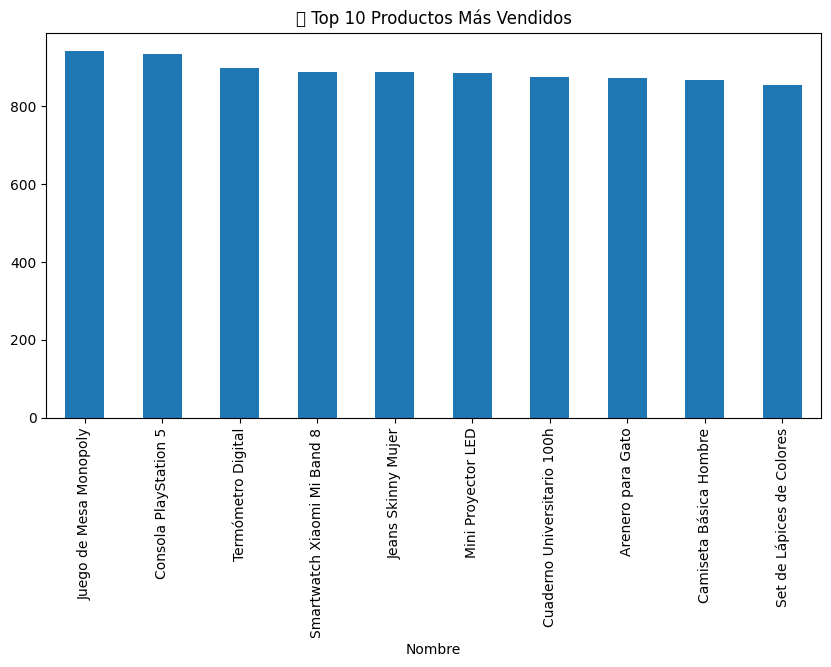

In [19]:
# Grafico para ver los 10 productos mas vendidos
query = """
SELECT p.Nombre, SUM(d.Cantidad) AS TotalVendidos
FROM DetalleOrdenes d
JOIN Productos p ON d.ProductoID = p.ProductoID
GROUP BY p.Nombre
ORDER BY TotalVendidos DESC
LIMIT 10
"""
df_top_productos = pd.read_sql(query, engine)
df_top_productos.plot(kind="bar", x="Nombre", y="TotalVendidos", title="🔝 Top 10 Productos Más Vendidos", figsize=(10, 5), legend=False)


<Axes: title={'center': '📈 Evolución de ingresos diarios'}, xlabel='Fecha'>

p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  func(*args, **kwargs)
p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


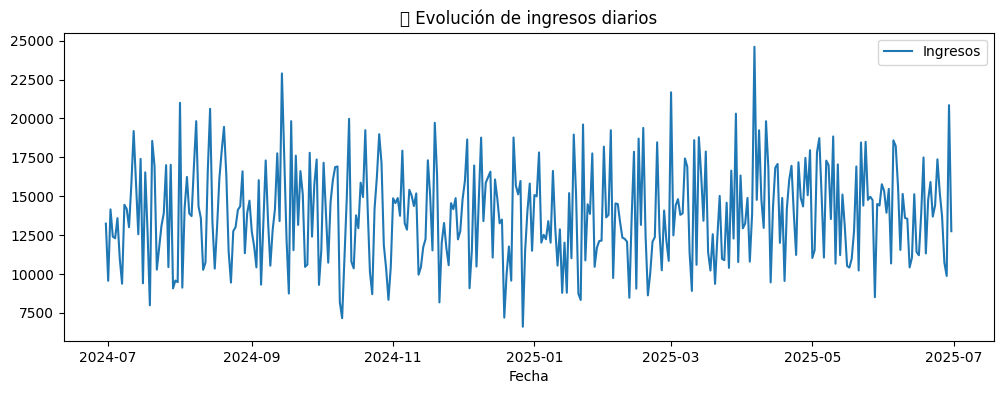

In [20]:
# Grafico para ver la evolucion de ingresos diarios
query = """
SELECT DATE(FechaOrden) AS Fecha, SUM(Total) AS Ingresos
FROM Ordenes
GROUP BY Fecha
ORDER BY Fecha
"""
df_ingresos = pd.read_sql(query, engine)
df_ingresos.plot(x="Fecha", y="Ingresos", kind="line", title="📈 Evolución de ingresos diarios", figsize=(12, 4))

<Axes: title={'center': '👤 Top 10 usuarios compradores'}, xlabel='Nombre'>

p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from current font.
  func(*args, **kwargs)
p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128100 (\N{BUST IN SILHOUETTE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


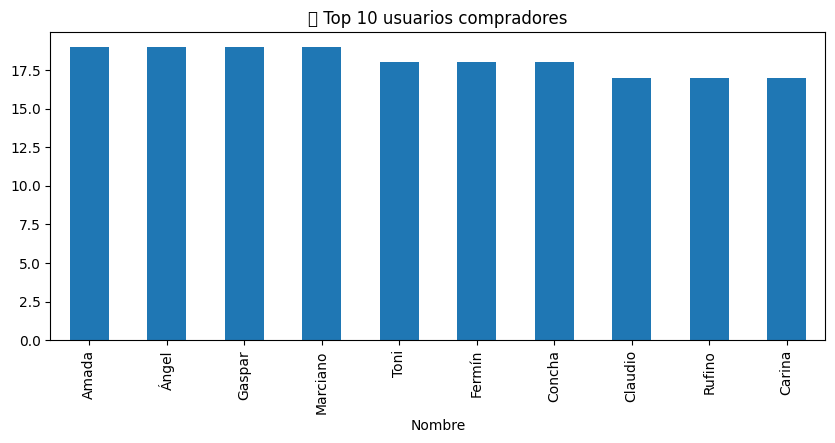

In [21]:
# Grafico para ver los 10 usuarios que mas compran
query = """
SELECT u.Nombre, u.Apellido, COUNT(o.OrdenID) AS CantCompras
FROM Usuarios u
JOIN Ordenes o ON u.UsuarioID = o.UsuarioID
GROUP BY u.UsuarioID
ORDER BY CantCompras DESC
LIMIT 10
"""
df_top_usuarios = pd.read_sql(query, engine)
df_top_usuarios.plot(kind="bar", x="Nombre", y="CantCompras", title="👤 Top 10 usuarios compradores", figsize=(10, 4), legend=False)


<Axes: title={'center': '⭐ Distribución de calificaciones'}, xlabel='Calificacion'>

p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  func(*args, **kwargs)
p:\Accenture_Henry\M1_Integrador\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


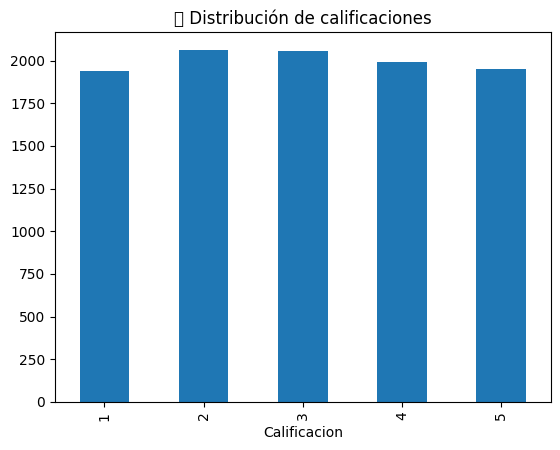

In [22]:
# Grafico para ver la distribucion de las calificaciones

query = "SELECT Calificacion FROM ReseñasProductos"
df_calif = pd.read_sql(query, engine)
df_calif['Calificacion'].value_counts().sort_index().plot(kind='bar', title="⭐ Distribución de calificaciones")


In [ ]:
# Se cierra conexion con la base
engine.dispose()